In [6]:
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd
from genplasmid.datasets import genbank_to_glm2, read_genbank
import warnings
from datasets import load_dataset

from Bio import BiopythonParserWarning

# Suppress the specific warning
warnings.filterwarnings("ignore", category=BiopythonParserWarning, message="Attempting to parse malformed locus line:")

In [31]:
data = load_dataset("wconnell/openplasmid")
data = data.filter(lambda x: x['GenBank Raw'] != '')
data = data.map(lambda x: {'glm2_sequence': genbank_to_glm2(x['GenBank Raw'])})
all_feat = data['train'].to_pandas()

In [184]:
# Load the model and tokenizer (if not already loaded)
model = AutoModel.from_pretrained('tattabio/gLM2_150M', torch_dtype=torch.bfloat16, trust_remote_code=True).cuda()
tokenizer = AutoTokenizer.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)

In [185]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm

# Create dataloaders
# Define a function to tokenize the sequences
def tokenize_function(examples):
    return tokenizer(examples['glm2_sequence'], truncation=True, padding='max_length', max_length=2048)

# Apply tokenization to the datasets
data = data.map(tokenize_function, batched=True)

# Set the format of the datasets to return PyTorch tensors
data.set_format(type='torch', columns=['input_ids', 'attention_mask'])

Map: 100%|██████████| 144691/144691 [03:25<00:00, 704.65 examples/s]


In [187]:
# Function to generate embeddings
def generate_embeddings(dataloader):
    embeddings = []
    model.eval()
    device = model.device  # Get the device of the model
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating embeddings"):
            batch_embeddings = model(input_ids=batch['input_ids'].to(device), output_hidden_states=True).last_hidden_state
            embeddings.extend(batch_embeddings.mean(dim=1).float().cpu().numpy())
    return np.array(embeddings)

# Create dataloaders
dataloader = DataLoader(data['train'], batch_size=128, shuffle=False)

# Generate embeddings for train and eval datasets
embeddings = generate_embeddings(dataloader)

print(f"Train embeddings shape: {embeddings.shape}")
np.save('data/glm2_embeddings.npy', embeddings)

Generating embeddings:   0%|          | 0/1131 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 1131/1131 [56:22<00:00,  2.99s/it]


Train embeddings shape: (144691, 640)


## Embeddings analysis

In [37]:
# def get_addgene_genes(x):
#     result = []
#     for key in x.keys():
#         if 'Gene/Insert' in key:
#             # Check if x[key] is a dictionary before accessing 'Entrez Gene'
#             if isinstance(x[key], dict) and 'Entrez Gene' in x[key]:
#                 out = x[key]['Entrez Gene']
#                 if out != '':
#                     result.append(out)
#     if result:
#         return pd.DataFrame.from_records({'ID': [x['ID']] * len(result), 'Gene/Insert': result})

# train_insert = pd.concat([get_addgene_genes(x) for x in data['train']])


In [4]:
import re

def clean_gene_name(gene):
    # Remove common prefixes and suffixes
    gene = re.sub(r'^(human|mouse|rat|h|m|r)\s*', '', gene, flags=re.IGNORECASE)
    gene = re.sub(r'\s*(gene|protein)$', '', gene, flags=re.IGNORECASE)
    
    # Remove parentheses and their contents
    gene = re.sub(r'\s*\([^)]*\)', '', gene)
    
    # Remove specific strings
    gene = re.sub(r'(or nptII)', '', gene)
    
    # Standardize common gene names
    gene_map = {
        'neo': 'neomycin resistance',
        'amp': 'ampicillin resistance',
        'gfp': 'GFP',
        'egfp': 'GFP',
        'rfp': 'RFP',
        'dsred': 'RFP',
        'kan': 'kanamycin resistance',
    }
    
    for key, value in gene_map.items():
        if re.search(rf'\b{key}\b', gene, re.IGNORECASE):
            return value
    
    return gene.strip().lower()

def extract_cds_genes(record):
    genes = []
    for feature in record.features:
        if feature.type == 'CDS':
            gene = feature.qualifiers.get('gene', [])
            product = feature.qualifiers.get('product', [])
            if gene:
                genes.append(clean_gene_name(gene[0]))
            elif product:
                genes.append(clean_gene_name(product[0]))
    return genes

def calculate_gc_content(sequence):
    gc_count = sequence.count('G') + sequence.count('C')
    total_count = len(sequence)
    return gc_count / total_count if total_count > 0 else 0

In [5]:
# extract sequence features
all_feat['GenBank'] = all_feat['GenBank Raw'].map(read_genbank)
all_feat['CDS genes'] = all_feat['GenBank'].map(extract_cds_genes)
all_feat['Sequence length'] = all_feat['GenBank'].map(lambda x: len(x.seq))
all_feat['GC content'] = all_feat['GenBank'].map(calculate_gc_content)

In [6]:
from collections import Counter
import itertools

# Count gene occurrences
gene_counts = Counter(list(itertools.chain.from_iterable(all_feat['CDS genes'].values)))

# Get the top 20 most common genes
top_20_genes = dict(gene_counts.most_common(20))
top_20_genes

{'bla': 87025,
 'GFP': 29536,
 'factor xa recognition and cleavage site': 24160,
 '6xhis affinity tag': 23993,
 'aph-ii': 20187,
 'antigenic peptide corresponding to amino acids 655 to 669 of the hiv envelope protein gp41': 19299,
 'nuclear localization signal of sv40 large t antigen': 18889,
 'pac from streptomyces alboniger': 16844,
 'aph-ia': 15933,
 'aminoglycoside phosphotransferase': 14731,
 'a epitope tag': 11084,
 'laci': 9892,
 'flag epitope tag, followed by an enterokinase cleavage site': 9523,
 'op': 8504,
 'RFP': 8281,
 'tobacco etch virus protease recognition and cleavage site': 8225,
 'cas9 endonuclease from the streptococcus pyogenes type ii crispr/cas system': 7906,
 'epitope tag from simian virus 5': 7229,
 'yc epitope tag': 6547,
 'cat': 6208}

In [15]:
def map_genes(genes):
    keywords = ['gfp', 'cas9', '6xhis', 'RFP', 'factor xa', 'aph-ii', 'aph-ia', 'laci', ' op ', 't antigen']
    for gene in genes:
        for keyword in keywords:
            if re.search(keyword, gene, re.IGNORECASE):
                return keyword
    return None

all_feat['query_gene'] = all_feat['CDS genes'].map(map_genes)

# Display the first few rows to verify
print(all_feat[['CDS genes', 'query_gene']].head(10))

# Count of rows for each mapped gene and None
gene_counts = all_feat['query_gene'].value_counts(dropna=False)
print("\nCounts for each mapped gene:")
print(gene_counts)

# Percentage of rows with a mapped gene
mapped_percentage = (all_feat['query_gene'].notna().sum() / len(all_feat)) * 100
print(f"\nPercentage of rows with a mapped gene: {mapped_percentage:.2f}%")

                                           CDS genes query_gene
0  [baculovirus late expression factor 2, baculov...      6xhis
1                     [a epitope tag, a epitope tag]       None
2                  [epitope tag from simian virus 5]       None
3                               [6xhis affinity tag]      6xhis
4  [ii, v, vii, ix, viii, RFP, aminoglycoside pho...        RFP
5  [antigenic peptide corresponding to amino acid...  factor xa
6  [bla, ionally designed epitope tag that forms ...     aph-ia
7                                             [aada]       None
8  [aminoglycoside phosphotransferase, aph-ia, op...     aph-ia
9                                                 []       None

Counts for each mapped gene:
query_gene
None         54489
factor xa    15635
6xhis        15410
gfp          13899
aph-ii       12514
aph-ia       10046
t antigen     9401
RFP           6262
laci          4259
cas9          2776
Name: count, dtype: int64

Percentage of rows with a mapped gene:

In [12]:
import scanpy as sc

if 'embeddings' not in locals():
    embeddings = np.load('data/glm2_embeddings.npy')

adata = sc.AnnData(embeddings, obs=all_feat)
adata.obs['log(seq_len)'] = np.log10(adata.obs['Sequence length'])
sc.tl.pca(adata)
adata

/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 144691 × 640
    obs: 'Name', 'ID', 'Flame', 'Purpose', 'Depositing Lab', 'Publication', 'GenBank File', 'Sequence Type', 'GenBank Raw', 'Backbone', 'Growth in Bacteria', 'Terms and Licenses', 'References', 'Gene/Insert 1', 'Cloning Information for Gene/Insert 1', 'Gene/Insert 2', 'Cloning Information for Gene/Insert 2', 'Gene/Insert 3', 'Cloning Information for Gene/Insert 3', 'GenBank', 'CDS genes', 'Sequence length', 'GC content', 'query_gene'

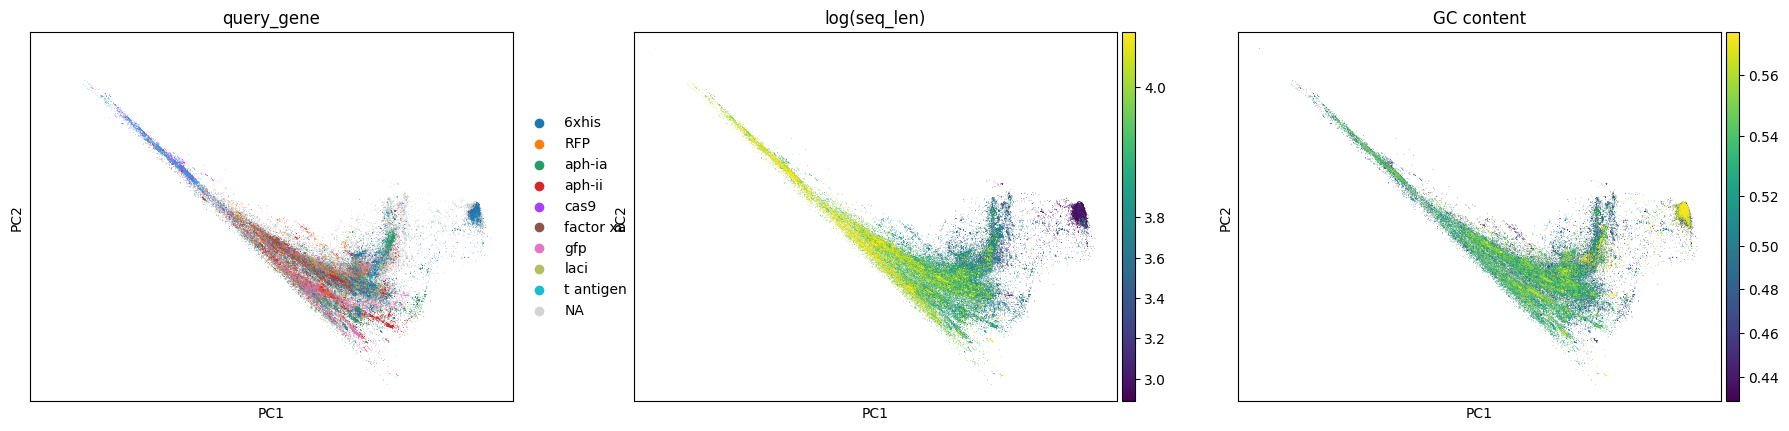

In [18]:
sc.pl.pca(
    adata, 
    color=['query_gene', 'log(seq_len)', 'GC content'],
    palette=sc.pl.palettes.vega_20_scanpy,
    ncols=3,
    vmin='p5',
    vmax='p95',
    vcenter='p50'
)

(-100.0, 30000.0)

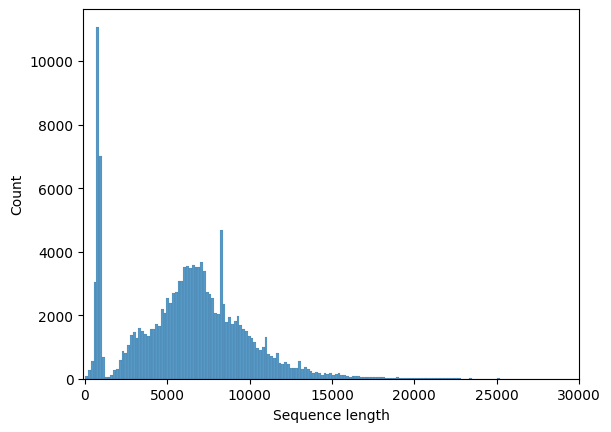

<Axes: xlabel='log(seq_len)', ylabel='Count'>

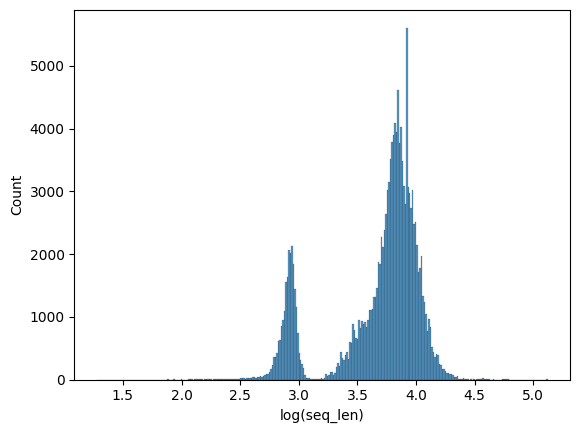

In [19]:
ax = sns.histplot(adata.obs['Sequence length'])
ax.set_xlim((-100, 3e4))
plt.show()
sns.histplot(adata.obs['log(seq_len)'])
plt.show()

(0.0, 30000.0)

Text(0.5, 0, 'PCA1')

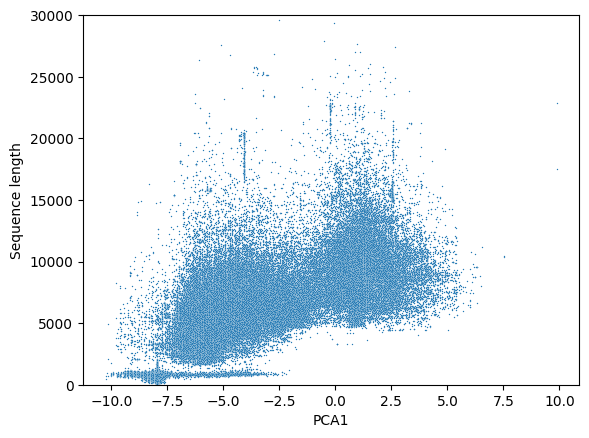

In [20]:
ax = sns.scatterplot(x=adata.X[:, 0], y=adata.obs['Sequence length'], s=1)
ax.set_ylim(0, 30000)
ax.set_xlabel('PCA1')
plt.show()

## Finetune

In [22]:
# # setup datasets
# data = load_dataset("wconnell/openplasmid")
# data = data.filter(lambda x: x['GenBank Raw'] != '')
# ft_data = data['train'].train_test_split(test_size=0.2)
# ft_data = ft_data.map(lambda x: {'glm2_sequence': genbank_to_glm2(x['GenBank Raw'])})

def tokenize_function(examples):
    return tokenizer(examples['glm2_sequence'], truncation=True, padding='max_length', max_length=2048)

# Apply tokenization to the datasets
ft_data = ft_data.map(tokenize_function, batched=True)

# Set the format of the datasets to return PyTorch tensors
ft_data.set_format(type='torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/115752 [00:00<?, ? examples/s]

Map: 100%|██████████| 28939/28939 [00:50<00:00, 574.32 examples/s]


In [33]:
ft_data = ft_data.filter(lambda x: x['glm2_sequence'] != '')
ft_data

Filter: 100%|██████████| 28939/28939 [00:17<00:00, 1688.73 examples/s]


DatasetDict({
    train: Dataset({
        features: ['Name', 'ID', 'Flame', 'Purpose', 'Depositing Lab', 'Publication', 'GenBank File', 'Sequence Type', 'GenBank Raw', 'Backbone', 'Growth in Bacteria', 'Terms and Licenses', 'References', 'Gene/Insert 1', 'Cloning Information for Gene/Insert 1', 'Gene/Insert 2', 'Cloning Information for Gene/Insert 2', 'Gene/Insert 3', 'Cloning Information for Gene/Insert 3', 'glm2_sequence', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 111057
    })
    test: Dataset({
        features: ['Name', 'ID', 'Flame', 'Purpose', 'Depositing Lab', 'Publication', 'GenBank File', 'Sequence Type', 'GenBank Raw', 'Backbone', 'Growth in Bacteria', 'Terms and Licenses', 'References', 'Gene/Insert 1', 'Cloning Information for Gene/Insert 1', 'Gene/Insert 2', 'Cloning Information for Gene/Insert 2', 'Gene/Insert 3', 'Cloning Information for Gene/Insert 3', 'glm2_sequence', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27727

In [37]:
from transformers import AutoModelForMaskedLM, AutoTokenizer, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer
import torch
import numpy as np


# Load the pre-trained model and tokenizer
model = AutoModelForMaskedLM.from_pretrained('tattabio/gLM2_150M', torch_dtype=torch.bfloat16, trust_remote_code=True).cuda()
tokenizer = AutoTokenizer.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)


# Create a data collator for masked language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm_probability=0.15
)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./data/models/finetune",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=5, # effective batch size of (per_device_bs * n_device * accum_steps)
    save_steps=10_000,
    save_total_limit=5,
    logging_dir='./data/models/finetune/logs',
    logging_steps=1,  # Log every step
    eval_strategy="epoch",  # Evaluate at the end of each epoch
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ft_data['train'],
    eval_dataset=ft_data['test'],
    data_collator=data_collator,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./data/models/finetune/final-model")

/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
 

Epoch,Training Loss,Validation Loss
0,0.791000,0.672891
1,0.738300,0.557597
2,0.488300,0.534424
3,0.582500,0.528503
4,0.614300,0.528701


/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=6940, training_loss=0.6939776857579476, metrics={'train_runtime': 29549.7564, 'train_samples_per_second': 18.792, 'train_steps_per_second': 0.235, 'total_flos': 1.0578373677416448e+18, 'train_loss': 0.6939776857579476, 'epoch': 4.998559492941515})

<Figure size 700x450 with 0 Axes>

Text(0.5, 1.0, 'Training and Evaluation Loss over Steps')

Text(0.5, 0, 'Step')

Text(0, 0.5, 'Loss')

Text(5, 5, 'Train Start: 5.3516')

Text(-5, 5, 'Train End: 0.6143')

Text(5, -5, 'Eval Start: 0.6729')

Text(-5, -5, 'Eval End: 0.5285')

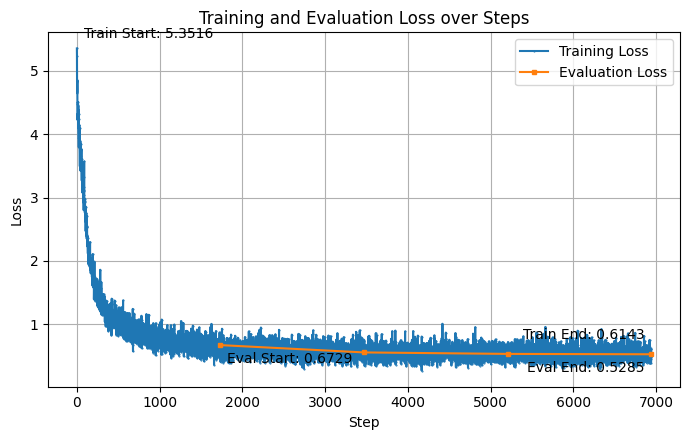

Final training loss: 0.6143
Final evaluation loss: 0.5285


In [47]:
# Plot the training and evaluation loss
import matplotlib.pyplot as plt
import json

# Extract the loss values from the training output
if 'trainer' not in locals() or not hasattr(trainer.state, 'log_history'):
    log_history = json.load(open('data/models/finetune/checkpoint-6940/trainer_state.json'))
    loss_values = log_history['log_history']
else:
    loss_values = trainer.state.log_history

# Extract 'loss' and 'eval_loss' from each dictionary in the list
train_losses = [log['loss'] for log in loss_values if 'loss' in log]
eval_losses = [log['eval_loss'] for log in loss_values if 'eval_loss' in log]
train_steps = list(range(1, len(train_losses) + 1))
eval_steps = [step * (len(train_losses) // len(eval_losses)) for step in range(1, len(eval_losses) + 1)]

# Create the plot
plt.figure(figsize=(7, 4.5))
plt.plot(train_steps, train_losses, marker='o', markersize=0.5, label='Training Loss')
plt.plot(eval_steps, eval_losses, marker='s', markersize=3, label='Evaluation Loss')
plt.title('Training and Evaluation Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Add text annotations for start and end loss values
plt.annotate(f'Train Start: {train_losses[0]:.4f}', xy=(1, train_losses[0]), xytext=(5, 5), 
             textcoords='offset points', ha='left', va='bottom')
plt.annotate(f'Train End: {train_losses[-1]:.4f}', xy=(len(train_losses), train_losses[-1]), xytext=(-5, 5), 
             textcoords='offset points', ha='right', va='bottom')
plt.annotate(f'Eval Start: {eval_losses[0]:.4f}', xy=(eval_steps[0], eval_losses[0]), xytext=(5, -5), 
             textcoords='offset points', ha='left', va='top')
plt.annotate(f'Eval End: {eval_losses[-1]:.4f}', xy=(eval_steps[-1], eval_losses[-1]), xytext=(-5, -5), 
             textcoords='offset points', ha='right', va='top')

plt.tight_layout()
plt.show()

# Print the final losses
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final evaluation loss: {eval_losses[-1]:.4f}")


In [22]:
from transformers import AutoModel
import torch
from safetensors import safe_open

# Create the model from the config
model = AutoModel.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)

# Load the safetensors file
checkpoint_path = 'data/models/finetune/checkpoint-6940/model.safetensors'
with safe_open(checkpoint_path, framework="pt", device="cpu") as f:
    state_dict = {k: f.get_tensor(k) for k in f.keys()}

# Remove the 'glm2.' prefix from the keys if present
state_dict = {k.replace('glm2.', ''): v for k, v in state_dict.items()}

# Load the state dict into the model
incompatible_keys = model.load_state_dict(state_dict, strict=False)

print("Unexpected keys:", incompatible_keys.unexpected_keys)
print("Missing keys:", incompatible_keys.missing_keys)

# Move the model to GPU and convert to bfloat16
model = model.cuda().to(torch.bfloat16)

print("Model loaded successfully!")

Unexpected keys: ['lm_head.norm.weight', 'lm_head.proj_output.weight']
Missing keys: []
Model loaded successfully!


In [33]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)

# Function to generate embeddings
def generate_embeddings(dataloader):
    embeddings = []
    model.eval()
    device = model.device  # Get the device of the model
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating embeddings"):
            batch_embeddings = model(input_ids=batch['input_ids'].to(device), output_hidden_states=True).last_hidden_state
            embeddings.extend(batch_embeddings.mean(dim=1).float().cpu().numpy())
    return np.array(embeddings)

# Create dataloaders
# Define a function to tokenize the sequences
def tokenize_function(examples):
    return tokenizer(examples['glm2_sequence'], truncation=True, padding='max_length', max_length=2048)

# DO NOT run this as original embeddings computed on all the data
# filter out empty sequences
# data = data.filter(lambda x: x['glm2_sequence'] != '')

# Apply tokenization to the datasets
data = data.map(tokenize_function, batched=True)

# Set the format of the datasets to return PyTorch tensors
data.set_format(type='torch', columns=['input_ids', 'attention_mask'])

In [34]:
# Create dataloaders
dataloader = DataLoader(data['train'], batch_size=128, shuffle=False)

# Generate embeddings for train and eval datasets
ft_embeddings = generate_embeddings(dataloader)

print(f"Train embeddings shape: {ft_embeddings.shape}")
np.save('data/glm2_ft_embeddings.npy', ft_embeddings)

Generating embeddings: 100%|██████████| 1131/1131 [56:02<00:00,  2.97s/it]


Train embeddings shape: (144691, 640)


In [37]:
ft_adata = sc.AnnData(ft_embeddings, obs=all_feat)
ft_adata.obs['log(seq_len)'] = np.log10(ft_adata.obs['Sequence length'])
sc.tl.pca(ft_adata)
ft_adata

/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 144691 × 640
    obs: 'Name', 'ID', 'Flame', 'Purpose', 'Depositing Lab', 'Publication', 'GenBank File', 'Sequence Type', 'GenBank Raw', 'Backbone', 'Growth in Bacteria', 'Terms and Licenses', 'References', 'Gene/Insert 1', 'Cloning Information for Gene/Insert 1', 'Gene/Insert 2', 'Cloning Information for Gene/Insert 2', 'Gene/Insert 3', 'Cloning Information for Gene/Insert 3', 'GenBank', 'CDS genes', 'Sequence length', 'GC content', 'query_gene', 'log(seq_len)'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

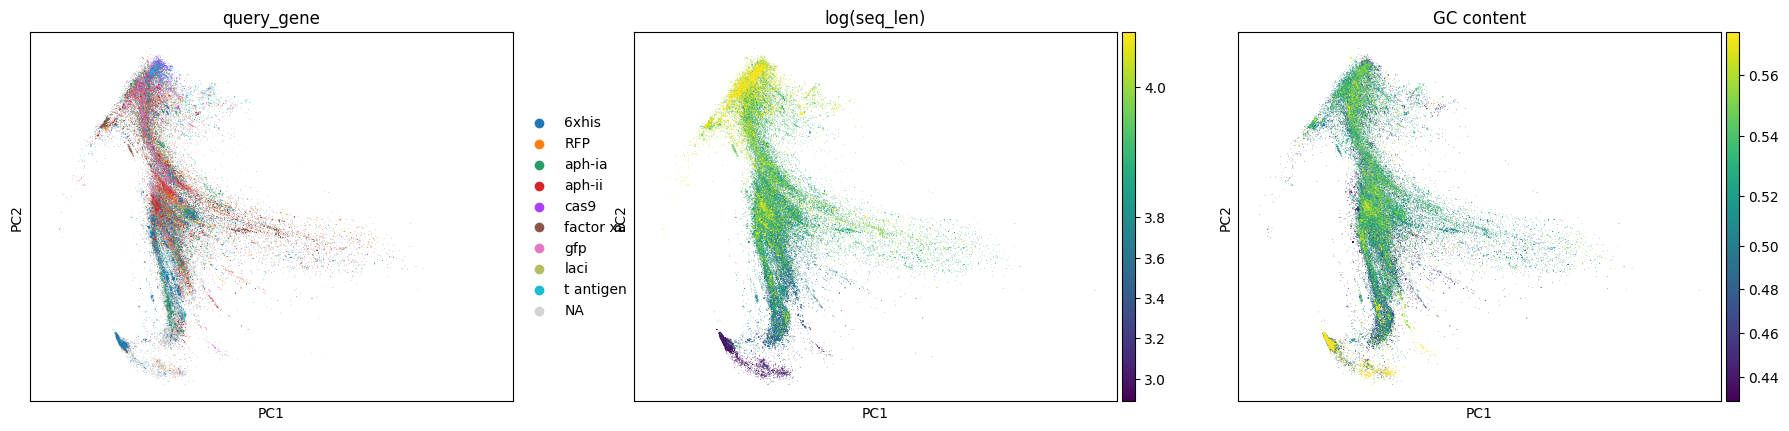

In [38]:
sc.pl.pca(
    ft_adata, 
    color=['query_gene', 'log(seq_len)', 'GC content'],
    palette=sc.pl.palettes.vega_20_scanpy,
    ncols=3,
    vmin='p5',
    vmax='p95',
    vcenter='p50'
)

## Generate sequences

In [2]:
import torch
from safetensors import safe_open
from transformers import AutoModelForMaskedLM, AutoTokenizer

load_finetuned = True

tokenizer = AutoTokenizer.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)

# Load finetuned model
if load_finetuned:
    print("Loading finetuned model")
    model = AutoModelForMaskedLM.from_pretrained('tattabio/gLM2_150M', torch_dtype=torch.bfloat16, trust_remote_code=True).cuda()
    # Load the safetensors file
    checkpoint_path = 'data/models/finetune/checkpoint-6940/model.safetensors'
    with safe_open(checkpoint_path, framework="pt", device="cpu") as f:
        state_dict = {k: f.get_tensor(k) for k in f.keys()}

    # Load the state dict into the model
    incompatible_keys = model.load_state_dict(state_dict, strict=False)
    print(incompatible_keys)
else:
    None
    # print("Loading pretrained model")
    # model = AutoModelForMaskedLM.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True).cuda()

/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading finetuned model
<All keys matched successfully>


In [6]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from genplasmid.datasets import genbank_to_glm2, read_genbank

tokenizer = AutoTokenizer.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)

# Create dataloaders
# Define a function to tokenize the sequences
def tokenize_function(examples):
    return tokenizer(examples['glm2_sequence'], truncation=True, padding='max_length', max_length=2048)

data = load_dataset("wconnell/openplasmid")
data = data.filter(lambda x: x['GenBank Raw'] != '')
data = data.map(lambda x: {'glm2_sequence': genbank_to_glm2(x['GenBank Raw'])})
# all_feat = data['train'].to_pandas()

# Apply tokenization to the datasets
data = data.map(tokenize_function, batched=True)

# Set the format of the datasets to return PyTorch tensors
data.set_format(type='torch', columns=['input_ids', 'attention_mask'])

dataloader = DataLoader(data['train'], batch_size=64, shuffle=False)


In [7]:
# Set the model to evaluation mode
device = model.device
model.eval()

predictions = []

for i, batch in enumerate(dataloader):
    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        logits = outputs.logits
        
        # Generate predicted sequences
        predicted_token_ids = torch.argmax(logits, dim=-1)
        predicted_sequences = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=True)
        
        predictions.extend(predicted_sequences)
    if i == 1:
        break

# Print a sample of predictions
print("Sample predictions:")
for i, pred in enumerate(predictions[:5]):
    print(f"Prediction {i+1}: {pred}")

gLM2ForMaskedLM(
  (glm2): gLM2Model(
    (tok_embeddings): Embedding(4160, 640)
    (encoder): TransformerLayers(
      (layers): ModuleList(
        (0-29): 30 x TransformerBlock(
          (attention): Attention(
            (wqkv): Linear(in_features=640, out_features=1920, bias=False)
            (wo): Linear(in_features=640, out_features=640, bias=False)
            (rotary_emb): RotaryEmbedding()
          )
          (feed_forward): FeedForward(
            (w1): Linear(in_features=640, out_features=1792, bias=False)
            (w2): Linear(in_features=1792, out_features=640, bias=False)
            (w3): Linear(in_features=640, out_features=1792, bias=False)
          )
          (attention_norm): RMSNorm()
          (ffn_norm): RMSNorm()
        )
      )
    )
  )
  (lm_head): gLM2LMHead(
    (norm): RMSNorm()
    (proj_output): Linear(in_features=640, out_features=4160, bias=False)
  )
)

Sample predictions:
Prediction 1: <+> c cgg ctc c <+> c ct c c cc c cgcgg c c c ct c c ct cg c c c c c cg cc c c c c cg c c c c c c c c c c c c cg caa c ct c cg c cg ct c c c caa c c c c tggg ct ag <+> c c c cc c ct c c c c ct c c ct c c ct c cg c c cg c c c c ct gg c c ct cg caa c caa gaa c ct c c c ct c c c c c c ct c c ct c c c c <+> c c aggg c c c ct c c c c cc c c c c c c c ct c c ct c cg c c c c cgc c c ct c caa c c c c ct c ct c c cgg ct c c ct c c ct gt c cc ct ct c ct c c c ct c c ct c cg c c c c ct gaa ccg c c ct ct tccc c c c c ct gt ct <+> c c tggg ggg cg c cc c cg ct cg c cg c t <+> H L L I K S Q D V Y K P P N C Q K M K T V D K L C P F A G N C K G L N P I C N Y <+> M A V I F N N K Q L L A D N S I E K G G E L F L F N G S Y N I L E S Y V N P V L L K N G V I E L E E A A Y Y A G N I L Y K T D D P K F I D Y I N L I I K A T H S E E L P E N S T V V N Y R K T M R S G T I H P I K K D I Y I Y D N K K F T L Y D R Y I Y G Y D N N Y V N F Y E E K N E K E K E Y E E E D D K A S S L C E N

In [8]:
import re

def extract_capital_spans(sequence):
    # Find all spans of consecutive capital letters
    capital_spans = re.findall(r'[A-Z]+', sequence)
    return capital_spans

# Extract capital spans from the first prediction
first_prediction = predictions[0].replace(" ", "")
capital_spans = extract_capital_spans(first_prediction)

print("Capital spans extracted:")
for i, span in enumerate(capital_spans, 1):
    print(f"Span {i}: {span}")

# If there are no capital spans, print a message
if not capital_spans:
    print("No capital spans found in the sequence.")




Capital spans extracted:
Span 1: HLLIKSQDVYKPPNCQKMKTVDKLCPFAGNCKGLNPICNY
Span 2: MAVIFNNKQLLADNSIEKGGELFLFNGSYNILESYVNPVLLKNGVIELEEAAYYAGNILYKTDDPKFIDYINLIIKATHSEELPENSTVVNYRKTMRSGTIHPIKKDIYIYDNKKFTLYDRYIYGYDNNYVNFYEEKNEKEKEYEEEDDKASSLCENKIILSQINCESFENDFKYYLSDYNYAFSIIDNTTNVLVAFGLYR
Span 3: MIRPVETPTREIKKLDGLWAFSLDRENCGIDQRWWESPLTQSRTITVPGSFNDQFADADIKNYAGNVWYQRDVFIPKGWKGQRIVLRFDAVTHYGKVWVNGQEVMEHQGGYTPFEADVTPYVIAGKSVRITVCVNNELNWQTIPPGMVITDENGKKKQSYFHDFFNYAGIHRSVMLYTTPNTWVDDITVVTHVAKDCNQASVDWQVIANGDVSVELRDADQQVVATGTGTSGTLEVLNPHLWQPGEGYLYELCVTTKSQTECDIYPLRVGIRTVEVKGQQFLINHKPFYFTGFGRHEDADLRGKGFDNVLMVHDHALMDWIGANSYRTSHYPYAEEMLDWADEHGIVVIDETAAVGFSLSLGMGFEAGNKAKELYSEEAVNPETQEAHLQAIKELIARDKNHPSVVMWSIANEPDTRPQGAREYFAPLAEATRKLDPTRPITCVNVMFCDAHTDTISDLFDVLCLNRYYGWYVQSGDLESAEKVLEKELLAWQEKLHKPIIITEYGVDTLAGLHSMYTDMWSEEYQCAYLDMYHRVFDRVSAVVGEQVWNFADFATSQGILRVGGNKKGIFTRDRKPKSAAFLLQKRWTGMNFGEKPQQGGKQ
Span 4: HHHHHH
Span 5: HHHHHH
Span 6: PSLRQSLYNTIAYIERLLNIGTVNDSEITMLIADFYDLYSNYNIELPPPQALPRSRRPSVVQPAAP

<Figure size 1000x600 with 0 Axes>

(array([12.,  1.,  2., 11.,  4.,  3.,  7.,  3.,  5.,  7.,  4.,  5.,  4.,
         2.,  5.,  5.,  3.,  3.,  2.,  5.,  5.,  0.,  5.,  3.,  1.,  0.,
         0.,  0.,  1., 20.]),
 array([   0.        ,   68.26666667,  136.53333333,  204.8       ,
         273.06666667,  341.33333333,  409.6       ,  477.86666667,
         546.13333333,  614.4       ,  682.66666667,  750.93333333,
         819.2       ,  887.46666667,  955.73333333, 1024.        ,
        1092.26666667, 1160.53333333, 1228.8       , 1297.06666667,
        1365.33333333, 1433.6       , 1501.86666667, 1570.13333333,
        1638.4       , 1706.66666667, 1774.93333333, 1843.2       ,
        1911.46666667, 1979.73333333, 2048.        ]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of <pad> Tokens per Sequence')

Text(0.5, 0, 'Number of <pad> Tokens')

Text(0, 0.5, 'Frequency')

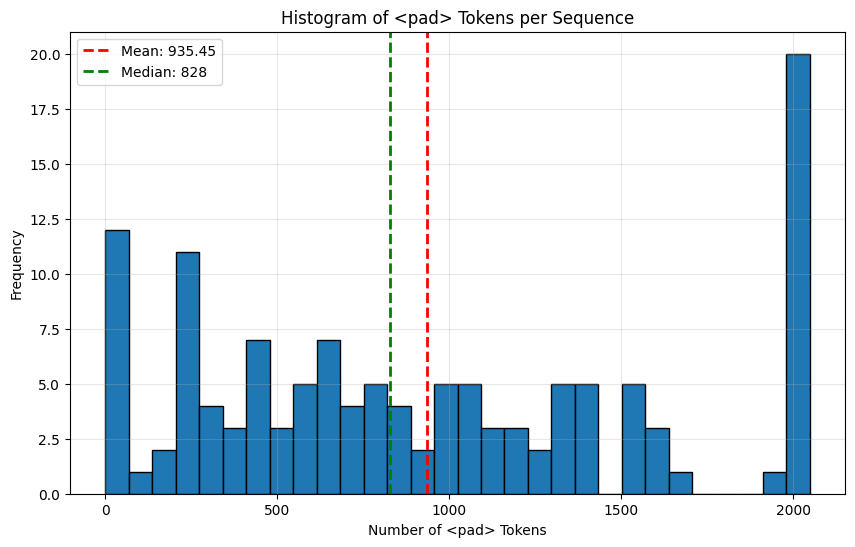

Total sequences: 128
Mean <pad> tokens per sequence: 935.45
Median <pad> tokens per sequence: 828
Max <pad> tokens in a sequence: 2048
Min <pad> tokens in a sequence: 0


In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to count <pad> tokens in a sequence
def count_pad_tokens(sequence):
    return sum(1 for token in sequence if token == 1)  # 1 is the integer for <pad>

# Count <pad> tokens for each sequence in the dataset
pad_counts = []
for i, batch in enumerate(dataloader):
    pad_counts.extend(count_pad_tokens(seq) for seq in batch['input_ids'])
    if i == 1:
        break

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(pad_counts, bins=30, edgecolor='black')
plt.title('Histogram of <pad> Tokens per Sequence')
plt.xlabel('Number of <pad> Tokens')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add some statistics
mean_pads = sum(pad_counts) / len(pad_counts)
median_pads = sorted(pad_counts)[len(pad_counts) // 2]
plt.axvline(mean_pads, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_pads:.2f}')
plt.axvline(median_pads, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_pads}')

plt.legend()
plt.show()

print(f"Total sequences: {len(pad_counts)}")
print(f"Mean <pad> tokens per sequence: {mean_pads:.2f}")
print(f"Median <pad> tokens per sequence: {median_pads}")
print(f"Max <pad> tokens in a sequence: {max(pad_counts)}")
print(f"Min <pad> tokens in a sequence: {min(pad_counts)}")